# Modeling Health Insurance Charges  

## Introduction 
This pratice project is based off a dataset that can be found on Kaggle. It contains records of medical insurance charges for patients.  Each patient in the dataset is recorded with the insurance charge, their age, gender, region in which they are located, number of children, and smoking status.   

A copy of the data set can be found here: https://www.kaggle.com/datasets/mirichoi0218/insurance 

## Dependencies

In [1]:
# Using Python 3.11.3 environment.  
#   May have to try different installed environments
## Python Packages 
import sys 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## R Packages 
import rpy2 
from rpy2.robjects.packages import importr 
from rpy2.robjects import pandas2ri
# To see plots in an output cell
from rpy2.ipython.ggplot import image_png
import rpy2.robjects.lib.ggplot2 as ggplot2


print("Python Version: " + sys.version)
print("rpy2 version: " + rpy2.__version__)

c:\Python311\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Python Version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
rpy2 version: 3.5.14


In [2]:
df = pd.read_csv("archive/insurance.csv")

# Create a R Dataframe from the Pandas Dataframe
with (rpy2.robjects.default_converter + pandas2ri.converter).context():
  rdf = rpy2.robjects.conversion.get_conversion().py2rpy(df)

## EDA 

### Previewing the Dataset

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Descriptive Statistics

#### Quantitative Variables

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
print("The percent difference between the median and average Charge: " + str( round( (13270.42 - 9382.03)/9382.03 * 100, 2)  ) + " percent.")

The percent difference between the median and average Charge: 41.45 percent.


The average and median ages are approximately 39 years, and the Q1 and Q3 ages are 27 and 51, respectively.   Average and median BMI are around 30, having Q1 and Q3 values of about 26 and just under 35 respectively.  The typical number of children is 1 child per family, with a Q3 value of 2 children per.  The average Charge is \$13,270.42 (approximately), which is higher than the median Charge of roughly \$9,382.03.  The Q1 and Q3 value of charges are about \$4,740.29 and \$16,639.91, respectively.  

This gives the impression that most people paying for insurance in this dataset are relatively young, and have relatively small families or are just starting families at the time of recording.  The fact that the average Charge is much higher than the median suggests that there are many insurance recipients who have premiums that are significantly higher.  For context, the percent difference from median to average Charge is about 41.45%.

#### Correlation Matrix of Quantitative Variables

<Axes: >

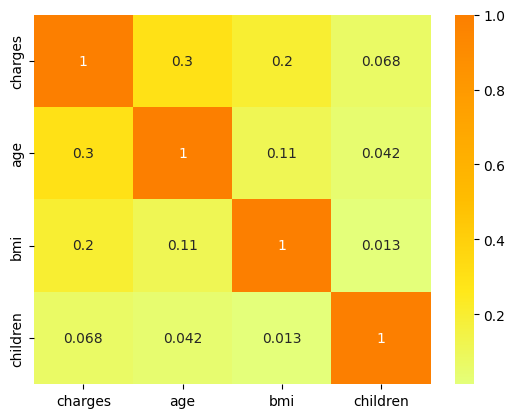

In [6]:
corr = df[['charges', 'age', 'bmi', 'children']].corr()
sns.heatmap(corr, cmap = 'Wistia', annot = True)

BMI and Age appear weakly correlated with Charges, so on their own they appear unlikely to play a significant role in determining what the ultimate Charge is.  The Number of Children appears even less tightly bound with Charges.  

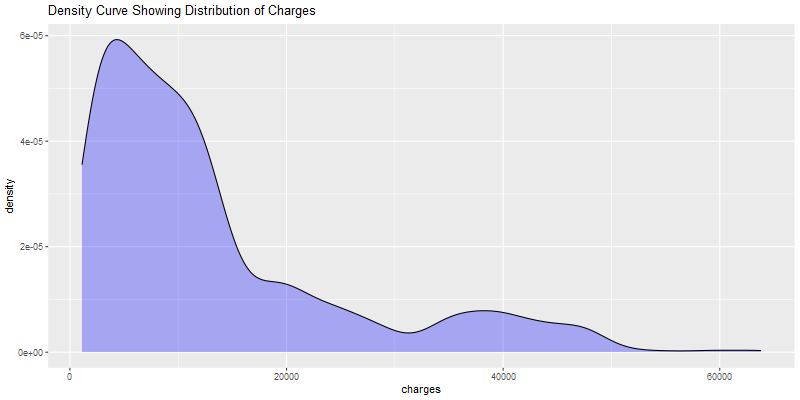

In [7]:
canvas = ggplot2.ggplot(rdf)

plot = (canvas + 
       ggplot2.aes_string( x = 'charges') + 
       ggplot2.geom_density(fill = 'blue', alpha = 0.3) + 
       ggplot2.labs(title = "Density Curve Showing Distribution of Charges")
       )

display(image_png(plot))

In prior iterations of data analysis, I attempted to control for outliers using Cooke's Distance and the 1.5*IQR Rule.  However, because the data is so spread out to begin with, what ended up happening was that I was left with so few viable observations so as to render it almost useless for training models.  Because of this, I am choosing not to enact controls for outliers in this iteration.  

#### Gender Statistics

In [8]:
print("Male to Female records in dataset: ")
print(df['sex'].value_counts())

Male to Female records in dataset: 
sex
male      676
female    662
Name: count, dtype: int64


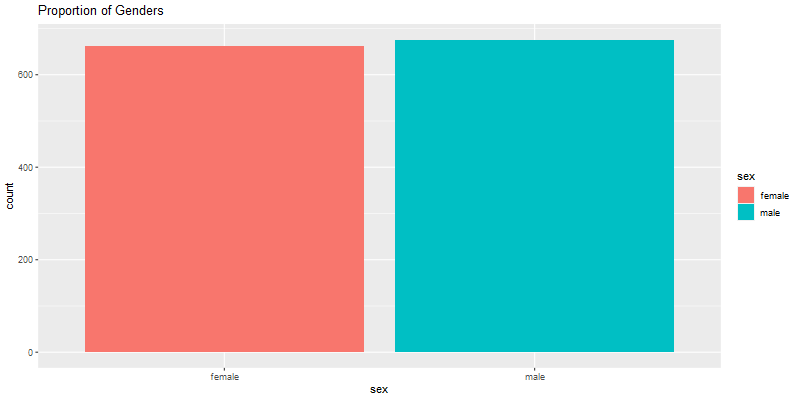

In [9]:
plot = (canvas + 
      ggplot2.aes_string(x = 'sex', fill = 'sex') + 
      ggplot2.geom_bar() + 
      ggplot2.labs(title = "Proportion of Genders"))

display(image_png(plot))

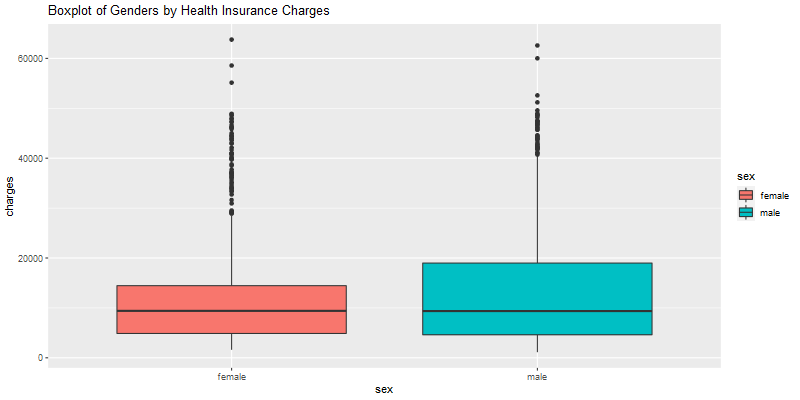

In [10]:
plot = (canvas + 
      ggplot2.aes_string(x = 'sex', y = 'charges', fill = 'sex') + 
      ggplot2.geom_boxplot() + 
      ggplot2.labs(title = "Boxplot of Genders by Health Insurance Charges") 
      )

display(image_png(plot))

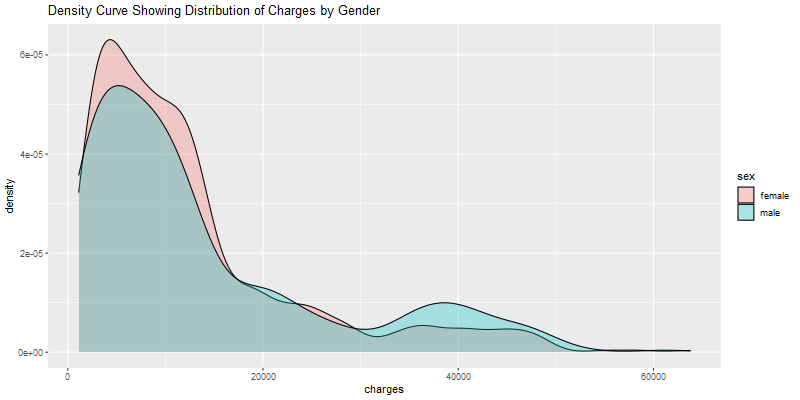

In [11]:
plot = (canvas + 
       ggplot2.aes_string( x = 'charges', fill = 'sex') + 
       ggplot2.geom_density(alpha = 0.3) + 
       ggplot2.labs(title = "Density Curve Showing Distribution of Charges by Gender")
       )

display(image_png(plot))

Based on these plots alone, it is clear that both Males and Females have approximately the same average and median values of Charges.  The distribution of Charges by Gender is pretty similar between males and females, however it does appear that men tend to have more high outlying values of Charges than women.  Finally, it appears that there are slightly more men than women present in the dataset, but with a difference of only 14, I do not think that is enough to cause a severe enough skew to warrant further intervention.  In conclusion, Gender ('Sex') does not appear to have a meaningful impact in determining the health insurance Charges of recipients.  

#### Region Statistics

In [12]:
print("Regional Proportions in the dataset: ")
print(df['region'].value_counts())

Regional Proportions in the dataset: 
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


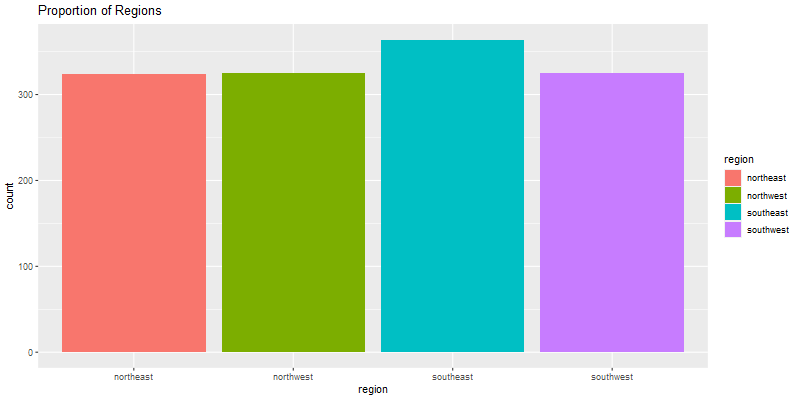

In [13]:
plot = (canvas + 
      ggplot2.aes_string(x = 'region', fill = 'region') + 
      ggplot2.geom_bar() + 
      ggplot2.labs(title = "Proportion of Regions"))

display(image_png(plot))

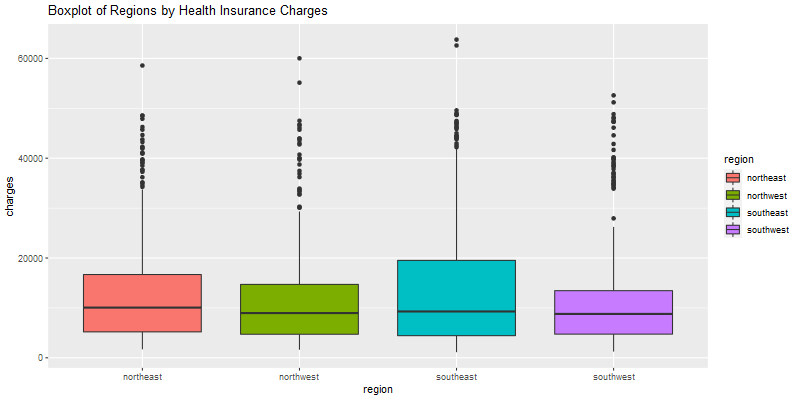

In [14]:
plot = (canvas + 
      ggplot2.aes_string(x = 'region', y = 'charges', fill = 'region') + 
      ggplot2.geom_boxplot() + 
      ggplot2.labs(title = "Boxplot of Regions by Health Insurance Charges") 
      )

display(image_png(plot))

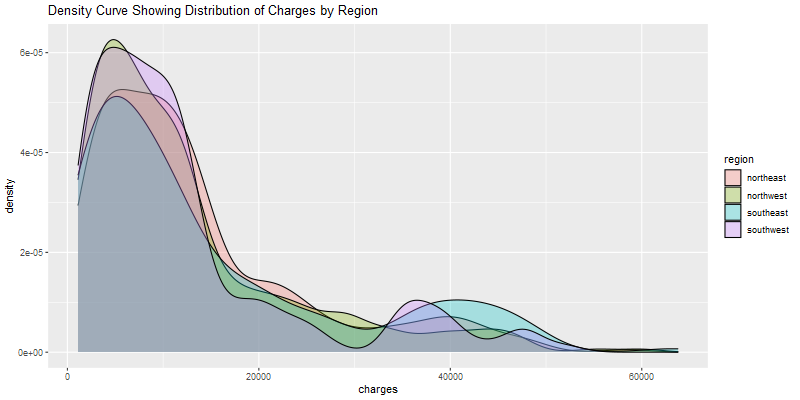

In [15]:
plot = (canvas + 
       ggplot2.aes_string( x = 'charges', fill = 'region') + 
       ggplot2.geom_density(alpha = 0.3) + 
       ggplot2.labs(title = "Density Curve Showing Distribution of Charges by Region")
       )

display(image_png(plot))

The Southeast Region is slightly over-represented by about 40 observations compared to the other regions.  While I do not think that is enough of a difference to distort anything, these charts do show that people living in the Southeast have a slightly higher tendency to incur higher health insurance charges.  All other regions seems more or less similar to each other by comparison.  This could imply that a categorical variable, Southeast vs Not-Southeast, could be a determining factor in predicting someone's health insurance charges.  

#### Smoking Status

In [16]:
print("Proportions by Smoking Status in the dataset: ")
print(df['smoker'].value_counts())

Proportions by Smoking Status in the dataset: 
smoker
no     1064
yes     274
Name: count, dtype: int64


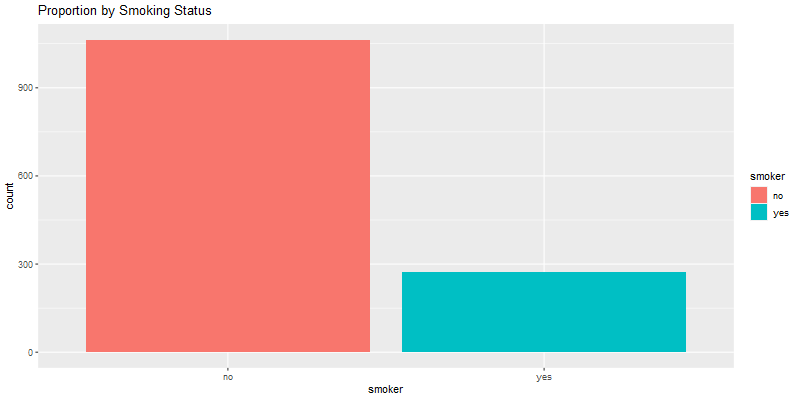

In [17]:
plot = (canvas + 
      ggplot2.aes_string(x = 'smoker', fill = 'smoker') + 
      ggplot2.geom_bar() + 
      ggplot2.labs(title = "Proportion by Smoking Status"))

display(image_png(plot))

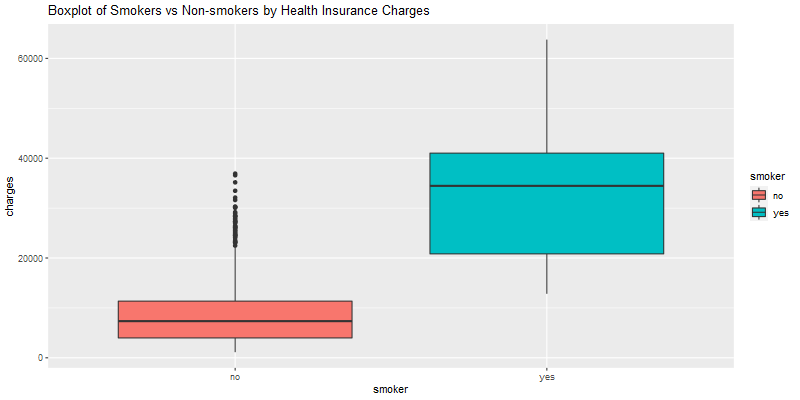

In [18]:
plot = (canvas + 
      ggplot2.aes_string(x = 'smoker', y = 'charges', fill = 'smoker') + 
      ggplot2.geom_boxplot() + 
      ggplot2.labs(title = "Boxplot of Smokers vs Non-smokers by Health Insurance Charges") 
      )

display(image_png(plot))

Even though Smokers are severely under-represented when compared to Non-Smokers, our boxplot shows that Smokers have significantly higher rates of health insurance charges.  Moving forward, we should consider building and evaluating models built on balanced and unbalanced datasets.  

#### Age Statistics

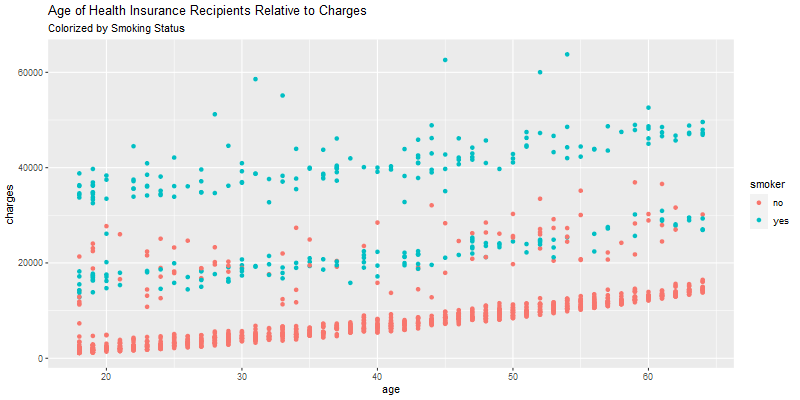

In [19]:
plot = (canvas + 
        ggplot2.aes_string(x = 'age', y = 'charges', colour = 'smoker') + 
        ggplot2.geom_point() + 
        ggplot2.labs(
            title = "Age of Health Insurance Recipients Relative to Charges", 
            subtitle = "Colorized by Smoking Status")
            )

display(image_png(plot))

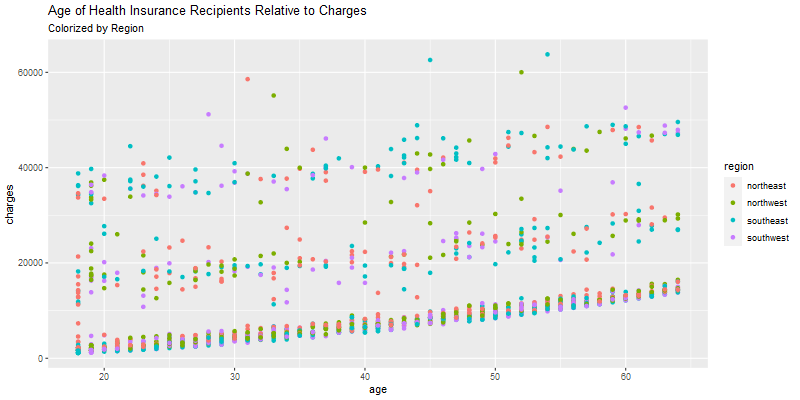

In [20]:
plot = (canvas + 
        ggplot2.aes_string(x = 'age', y = 'charges', colour = 'region') + 
        ggplot2.geom_point() + 
        ggplot2.labs(
            title = "Age of Health Insurance Recipients Relative to Charges", 
            subtitle = "Colorized by Region")
            )

display(image_png(plot))

As expected, it appears that people who are older tend to have higher insurance premiums than people who are younger.  When we colorize the chart by smoking status, we can see that there is a very clear split: smokers have an elevated baseline rate of health insurance costs than non-smokers.  Less apparent is the difference in region.   We certainly see a fair representation of recipients from the Southeast in the upper bands, but it is not obviously clear that it is significantly different from recipients of other regional backgrounds.  

#### BMI Statistics

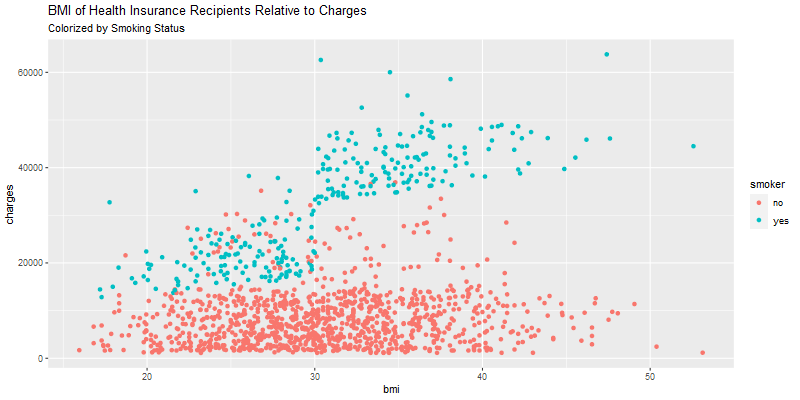

In [21]:
plot = (canvas + 
        ggplot2.aes_string(x = 'bmi', y = 'charges', colour = "smoker") + 
        ggplot2.geom_point() + 
        ggplot2.labs(
            title = "BMI of Health Insurance Recipients Relative to Charges", 
            subtitle = "Colorized by Smoking Status")
            )

display(image_png(plot))

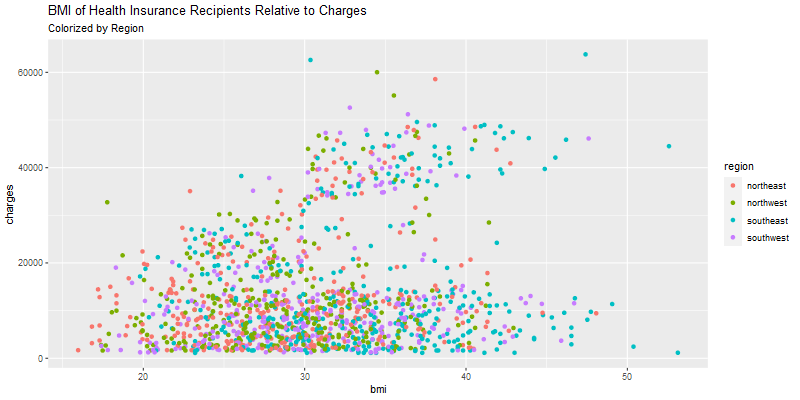

In [22]:
plot = (canvas + 
        ggplot2.aes_string(x = 'bmi', y = 'charges', colour = "region") + 
        ggplot2.geom_point() + 
        ggplot2.labs(
            title = "BMI of Health Insurance Recipients Relative to Charges", 
            subtitle = "Colorized by Region")
            )

display(image_png(plot))

BMI seems to only have an affect on elevating health insurance charges when twinned with a positive smoking status (i.e., recipients who smoke AND have a high BMI tend to have higher costs).   I think this might represent multicollinearity problems between BMI and Smoking Status, but it may not matter anyway.  Smoking Status is clearly more important than BMI, since it would seem that BMI alone does not consistently equate to higher health insurance charges.  Region also seems tobe less influential here: I just do not see an obvious pattern that we can latch onto.  

#### Statistics on the Quantity of Children of Health Insurance Recipients

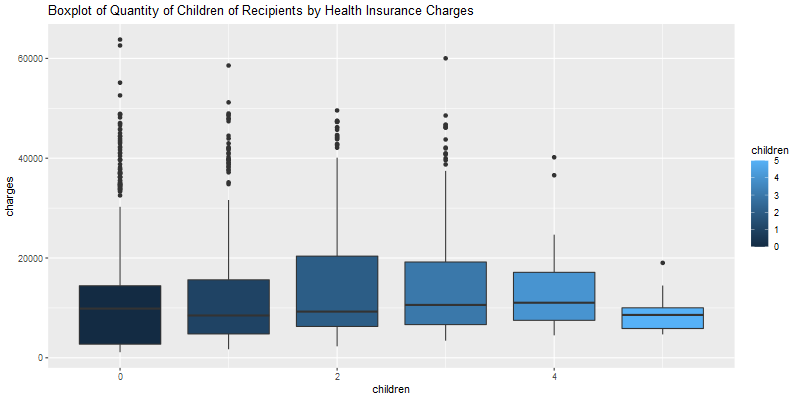

In [23]:
plot = (canvas + 
      ggplot2.aes_string(x = 'children', y = 'charges', fill = 'children', group = 'children') + 
      ggplot2.geom_boxplot() + 
      ggplot2.labs(title = "Boxplot of Quantity of Children of Recipients by Health Insurance Charges") 
      )

display(image_png(plot))

It is hard to definitely say whether the number of children really has an affect on health insurance charges.  The IQR seems to shift up as we go from 0 to 2 children per family, but after that it retracts.  We know that the average number of children per recipient is 1, and we also know that the correlation between number of children and health insurance charges is extremely low.  Ultimately, I do not think there is enough evidence to support inclusion of the quantity of children as a variable of any model, especially if I am trying to be parsimonious.  

#### Conclusions on EDA

Smoking Status, Region One-Hot Encoded for Southeast, and Age seem like the best candidates for inclusion in models.

### Creation of the Training and Testing Datasets 
Categorical Variable will be one-hot encoded, with region being one-hot encoded for Southeast.   

In [24]:
master_dataset = df
master_dataset["smoker"] = master_dataset["smoker"].replace(["yes", "no"], [1, 0])
master_dataset["sex"] = master_dataset["sex"].replace(["male", "female"], [1, 0])
master_dataset["region_southeast"] = master_dataset["region"].apply(lambda x: 1 if x == "southeast" else 0)

In [25]:
y = master_dataset["charges"]
X = master_dataset.drop(["charges", "region", "sex", "bmi", "children"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
X.head()

,age,smoker,region_southeast
0,19,1,0
1,18,0,1
2,28,0,1
3,33,0,0
4,32,0,0


In [27]:
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

### Linear Regression Model 1 
Linear Regression Model built on the normal dataset.  Variables included are Age, Smoking Status, and Region one-hot encoded for "Southeast". 

In [28]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [29]:
print("R-Squared: " + str(round(lm.score(X_train, y_train), 4)))
print("Mean Squared Error: " + str( round( mean_squared_error(y_test, y_pred), 4)))

R-Squared: 0.7174
Mean Squared Error: 39446937.3418


In [30]:
# Intercept and Coefficient 
print("The intercept for the model is " + str(lm.intercept_) +".")

for name, score in zip(["age", "smoker", "region_southeast"], lm.coef_): 
    print(name, score)

The intercept for the model is -2743.9161256803727.
age 280.1065012520578
smoker 23683.223036560234
region_southeast 643.8412434124384


#### Checking for Homoscedasticity 

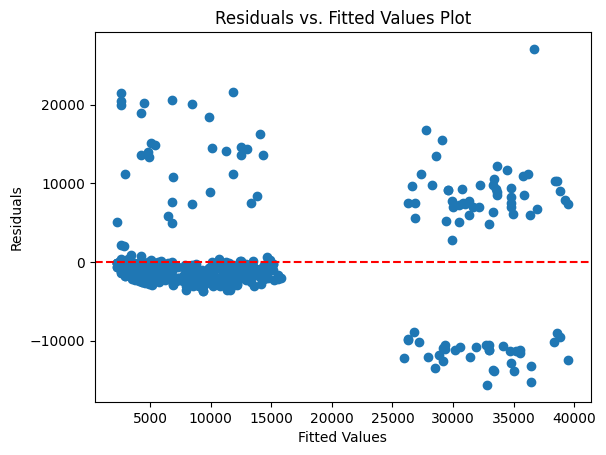

In [31]:
residuals = y_test - y_pred 

# Plot Residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values Plot')

plt.show()

#### Checking the Normality Assumption

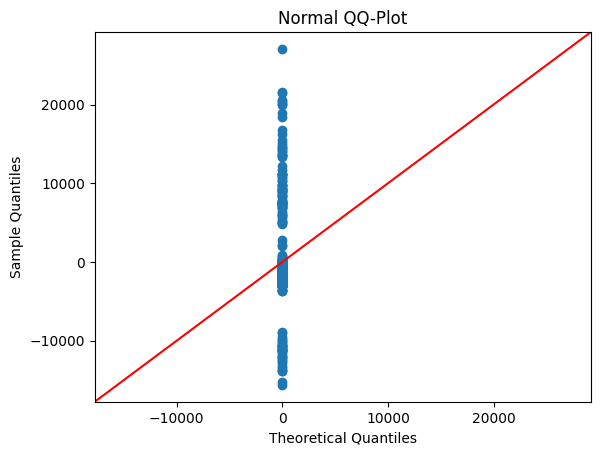

In [32]:
fig = sm.qqplot(residuals, line='45')
plt.title('Normal QQ-Plot')

plt.show()

The R-Squared is a respectable 0.7174, however the Mean Squared Error is quite high.  That is not necessarily a bad thing in and of itself, since its main utility is as a comparison between models.  Given that we know how widely charges can vary, it is perhaps not surprising that we see such a result.  

As expected Smoking Status was weighted the highest in terms of feature importance.  It was followed by Southeast Region and Age in that order of importance.  We might be able to take this as evidence that supports a conclusion that quality healthcare (at least as far as insurance is concerned) is more expensive in the Southeastern United States.

The appropriatness of using a linear model in this case is also questionable.  It looks as if Heteroskedasticity may be present, and the residuals do not seem to be normally distributed by an examination of the QQ Plot.  

### Random Forest Model 1
There is indication that this data does not meet all the ideal conditions for linear models.  It is then worth exploring how a non-linear based model compares to the linear model.

In [33]:
rm = RandomForestRegressor(n_estimators = 500, criterion = 'squared_error', max_depth = 3)
rm.fit(X_train, y_train)

y_pred = rm.predict(X_test)

In [34]:
print("Mean Squared Error: " + str( round( mean_squared_error(y_test, y_pred), 4)))

Mean Squared Error: 39198978.74


In [35]:
for name, score in zip(["age", "smoker", "region_southeast"], rm.feature_importances_): 
    print(name, score)

age 0.16690521080627227
smoker 0.8295106006468613
region_southeast 0.003584188546866469


The Mean Squared Error is remarkably similar between both models, although the Random Forest Classifier has a slightly lower MSE.  I interpret this as a sign that non-linear models are the way to go in this case, although developing something with a dramatically lower MSE may be difficult given how widely the charges vary in the training data.  

While both the linear model and the random forest model emphasize Smoking Status as having the greatest feature importance, the random forest model places less weight on the Southeast Region, meaning it might be premature to conclude that the Southeastern Region is significantly more expensive in terms of health insurance charges.  

### Conclusions 

There is some evidence that we can build reasonably accurate machine learning models to predict health insurance chages based on certain information regarding recipients.  The R-Squared for the linear model is farily high, and there is a glimmer that non-linear models may work best in this scenario.  

Although there is no true objective standard for what a good Mean Squared Error is (aside from comparisons between models), the high raw value of the Mean Squared Error gives me some pause.  If this were an actual real life scenario, I would definitely want to test these models on new data over the long term, to get a better sense regarding how suitable these models are for employment as a public health tool.  

Finally, there are some natural extensions I would like to consider at some point.  I could employ oversampling techniques to compensate for the disparity in Smokers vs Non-Smokers, and I could employ Cross-Validation techniques to more rigorously test the models.  I could also experiment with other non-linear models, namely neural networks, so see how they fair in comparison.  
